## Mouse Connectivity

This notebook demonstrates how to access and manipulate data in the Allen Mouse Brain Connectivity Atlas. The `MouseConnectivityCache` AllenSDK class provides methods for downloading metadata about experiments, including their viral injection site and the mouse's transgenic line. You can request information either as a Pandas DataFrame or a simple list of dictionaries.

An important feature of the `MouseConnectivityCache` is how it stores and retrieves data for you. By default, it will create (or read) a manifest file that keeps track of where various connectivity atlas data are stored. If you request something that has not already been downloaded, it will download it and store it in a well known location.

***
Note that probably the easiest way how to explore data on neuronal connectivity from this dataset is to download __[Brain Explorer](http://connectivity.brain-map.org/static/brainexplorer)__, a piece of software that allows you to browse 3D reconstructed data. You can also add layer of Gene expression. 

To view the data on connectivity, navigate to __[respective dataset](http://connectivity.brain-map.org/)__ in your browser, filter down for structure of interest, click on the search results and open the BrainExplorer software by clikcing on '3D' icon. These steps are documented in __[help](http://help.brain-map.org/display/mouseconnectivity/Projection)__.

In [1]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')

# open up a list of all of the experiments
all_experiments = mcc.get_experiments(dataframe=True)
print "%d total experiments" % len(all_experiments)

# take a look at what we know about an experiment with a primary motor injection
all_experiments.loc[122642490]

2546 total experiments


gender                                                                   M
id                                                               122642490
injection-coordinates                                   [4020, 2160, 6870]
injection-structures     [{u'abbreviation': u'MOp', u'color': u'1F9D5A'...
product-id                                                               5
strain                                                            C57BL/6J
structure-abbrev                                                       MOs
structure-color                                                     1F9D5A
structure-id                                                           993
structure-name                                        Secondary motor area
transgenic-line                                             Syt6-Cre_KI148
Name: 122642490, dtype: object

`MouseConnectivityCache` has a method for retrieving the adult mouse structure tree as an `StructureTree` class instance. This is a wrapper around a list of dictionaries, where each dictionary describes a structure. It is principally useful for looking up structures by their properties.

In [2]:
# pandas for nice tables
import pandas as pd

# grab the StructureTree instance
structure_tree = mcc.get_structure_tree()

# Obtain unique sets from the Structure tree
uniq_sets = structure_tree.get_structure_sets()
# Disasamble the sets to individual structures
uniq_structs = structure_tree.get_structures_by_set_id(uniq_sets)
# Make it presentable by converting to DF object
uniq_structs = pd.DataFrame(uniq_structs)
# You can look into uniq_structs to see all the available structs
# e.g. uniq_structs[['name', 'acronym']]
# You can also look them up online: http://connectivity.brain-map.org/

# Pick structures based on their name and acronym
# Here we go for barrel cortex
sel_structs = uniq_structs[uniq_structs['acronym'].str.contains('.*SS.*') &
             uniq_structs['name'].str.contains('.*barrel.*')]
# Use bitwise AND for querying in pandas:
# https://stackoverflow.com/questions/36921951/truth-value-of-a-series-is-ambiguous-use-a-empty-a-bool-a-item-a-any-o

# Look what we have
sel_structs[['name', 'id', 'acronym']]

,name,id,acronym
147,"Primary somatosensory area, barrel field, laye...",201,SSp-bfd2/3
250,"Primary somatosensory area, barrel field",329,SSp-bfd
768,"Primary somatosensory area, barrel field, layer 1",981,SSp-bfd1
811,"Primary somatosensory area, barrel field, laye...",1038,SSp-bfd6a
818,"Primary somatosensory area, barrel field, layer 4",1047,SSp-bfd4
830,"Primary somatosensory area, barrel field, laye...",1062,SSp-bfd6b
836,"Primary somatosensory area, barrel field, layer 5",1070,SSp-bfd5


As a convenience, structures are grouped in to named collections called "structure sets". These sets can be used to quickly gather a useful subset of structures from the tree. The criteria used to define structure sets are eclectic; a structure set might list:

* structures that were used in a particular project.
* structures that coarsely partition the brain.
* structures that bear functional similarity.

or something else entirely. To view all of the available structure sets along with their descriptions, follow this [link](http://api.brain-map.org/api/v2/data/StructureSet/query.json). To see only structure sets relevant to the adult mouse brain, use the StructureTree:

In [3]:
from allensdk.api.queries.ontologies_api import OntologiesApi

oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
structure_set_ids = structure_tree.get_structure_sets()

# query the API for information on those structure sets
pd.DataFrame(oapi.get_structure_sets(structure_set_ids))

,description,id,name
0,List of Primary injection structures for BDA/A...,114512892,Mouse Connectivity - BDA/AAV Primary Injection...
1,List of primary AND secondary injection struct...,112905813,Mouse Connectivity - BDA/AAV All Injection Str...
2,List of structures for ABA Fine Structure Search,10,ABA - Fine Structure Search
3,List of structures used for the Connectivity p...,167587189,Mouse Connectivity - Summary
4,List of primary AND secondary injection struct...,112905828,Mouse Connectivity - Projection All Injection ...
5,All mouse visual areas with layers,396673091,Mouse Cell Types - Structures
6,List of visual cortex structures targeted for ...,514166994,Allen Brain Observatory targeted structure set
7,List of structures for ABA Differential Search,12,ABA - Differential Search
8,List of structures representing a coarse level...,2,Mouse - Coarse
9,List of valid structures for projection target...,184527634,Mouse Connectivity - Target Search


This is how you can filter experiments by transgenic line:

In [4]:
# fetch the experiments that have injections in the isocortex of cre-positive mice
isocortex = structure_tree.get_structures_by_name(['Isocortex'])[0]
cre_cortical_experiments = mcc.get_experiments(cre=True, 
                                                injection_structure_ids=[isocortex['id']])

print "%d cre cortical experiments" % len(cre_cortical_experiments)

# same as before, but restrict the cre line
rbp4_cortical_experiments = mcc.get_experiments(cre=[ 'Rbp4-Cre_KL100' ], 
                                                injection_structure_ids=[isocortex['id']])


print "%d Rbp4 cortical experiments" % len(rbp4_cortical_experiments)

872 cre cortical experiments
81 Rbp4 cortical experiments


## Structure Signal Unionization

The ProjectionStructureUnionizes API data tells you how much signal there was in a given structure and experiment. It contains the density of projecting signal, volume of projecting signal, and other information. `MouseConnectivityCache` provides methods for querying and storing this data.

In [5]:
# find wild-type injections into selected areas
sel_experiments = mcc.get_experiments(cre=False, 
                                       injection_structure_ids=sel_structs['id'].values)

In [6]:
print "%d Selected experiments" % len(sel_experiments)

structure_unionizes = mcc.get_structure_unionizes([ e['id'] for e in sel_experiments ], 
                                                  is_injection=False,
                                                  structure_ids=[isocortex['id']],
                                                  include_descendants=True)

print "%d SS non-injection, cortical structure unionizes" % len(structure_unionizes)

6 Selected experiments
5292 SS non-injection, cortical structure unionizes


In [7]:
structure_unionizes.head()

,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,experiment_id,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
0,2,531728428,False,0.421149,8650,2040,9050,0.002136,0.040352,5.161780,127.920,0.000862,112951804,121,9.338650e+08,1.743300e+07,8.998530e+07,703451.0,0.021355
1,1,531727887,False,0.224033,7780,1130,3480,0.000184,0.000591,0.144610,244.838,0.000074,112951804,433,8.221220e+09,1.026090e+08,1.483820e+07,60604.3,0.125696
2,1,531728155,False,0.667943,8060,1010,4520,0.003462,0.001076,0.181058,168.214,0.001396,112951804,894,5.712530e+10,1.059130e+09,1.917630e+08,1140000.0,1.297430
3,1,531728078,False,0.817540,3920,1930,4500,0.036439,0.005952,1.263660,212.311,0.014701,112951804,767,1.503390e+11,2.016240e+09,2.547850e+09,12000600.0,2.469890
4,3,531729437,False,0.254416,2190,2980,6150,0.000398,0.000471,0.052688,111.892,0.000161,112951804,582,1.269270e+10,2.785840e+08,1.467810e+07,131181.0,0.341266


This is a rather large table, even for a relatively small number of experiments.  You can filter it down to a smaller list of structures like this.

In [8]:
dense_unionizes = structure_unionizes[ structure_unionizes.projection_density > .5 ]
large_unionizes = dense_unionizes[ dense_unionizes.volume > .5 ]
large_structures = pd.DataFrame(structure_tree.node(large_unionizes.structure_id))

print "%d large, dense, cortical, non-injection unionizes, %d structures" % ( len(large_unionizes), len(large_structures) )

print large_structures.name

large_unionizes

6 large, dense, cortical, non-injection unionizes, 6 structures
0    Primary somatosensory area, barrel field, layer 4
1    Primary somatosensory area, barrel field, laye...
2    Primary somatosensory area, barrel field, laye...
3             Primary somatosensory area, barrel field
4    Primary somatosensory area, barrel field, laye...
5    Primary somatosensory area, barrel field, layer 5
Name: name, dtype: object


,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,experiment_id,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
252,2,531729008,False,1.0,6220,1580,8560,1.243940,0.773477,1078.130,1393.88,0.501850,112951804,1047,5.947220e+11,5.296520e+08,5.710340e+11,4.096740e+08,0.648824
428,3,531729741,False,1.0,6830,2470,2040,1.634490,0.511879,689.725,1347.44,0.659410,112951804,1038,7.850080e+11,1.051600e+09,7.253170e+11,5.382940e+08,1.288210
491,2,531728478,False,1.0,6550,1350,8720,1.475380,0.713788,1067.740,1495.87,0.595219,112951804,201,7.624540e+11,6.807250e+08,7.268350e+11,4.858930e+08,0.833888
595,2,531728559,False,1.0,6370,2070,8160,5.787990,0.744712,1100.540,1477.80,2.335080,112951804,329,2.935530e+12,2.559630e+09,2.816970e+12,1.906190e+09,3.135550
689,2,531729002,False,1.0,6370,2070,8160,1.244390,0.873448,1398.250,1600.84,0.502032,112951804,1038,6.679170e+11,4.692000e+08,6.560600e+11,4.098220e+08,0.574770
793,2,531729021,False,1.0,6540,1740,8400,0.915495,0.674895,949.290,1406.58,0.369343,112951804,1070,4.502060e+11,4.467430e+08,4.240890e+11,3.015040e+08,0.547260


## Generating a Projection Matrix
The `MouseConnectivityCache` class provides a helper method for converting ProjectionStructureUnionize records for a set of experiments and structures into a matrix.  This code snippet demonstrates how to make a matrix of projection density values in sub-structures for cre-negative SS experiments. 

Higher value of projection density for particular cell corresponds to more axonal projections to particular region.

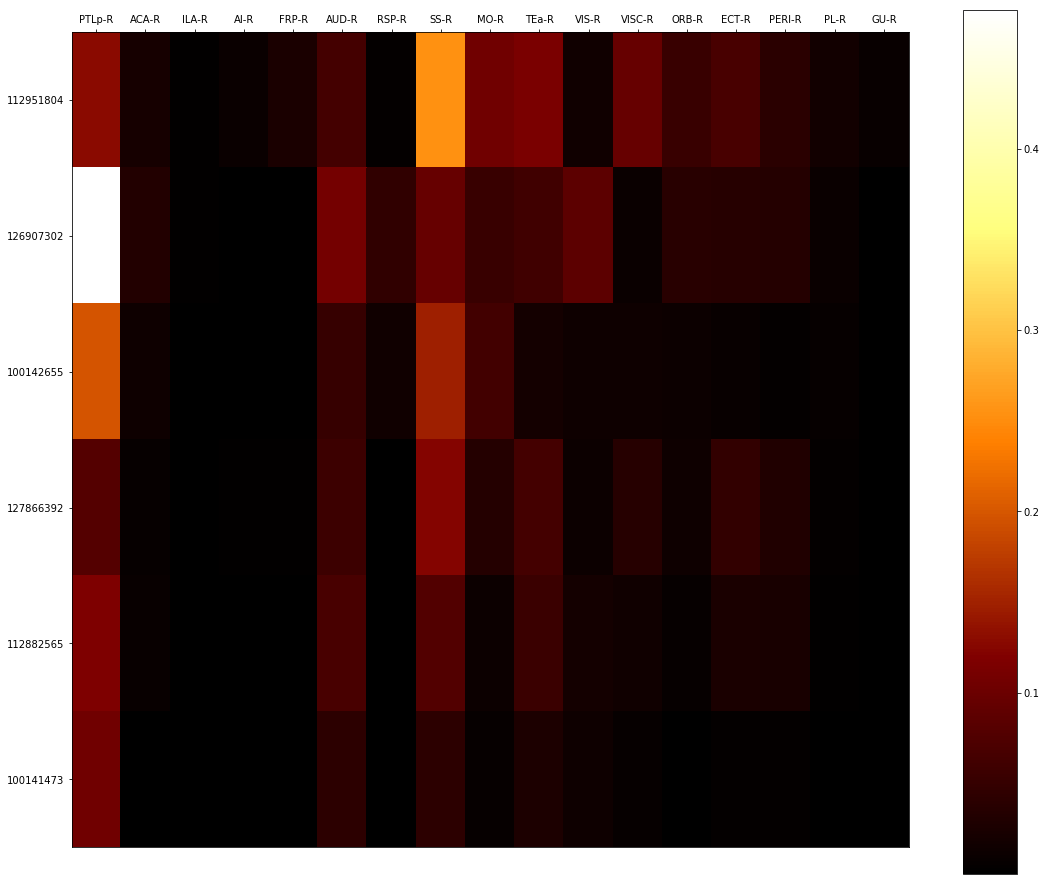

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

sel_experiment_ids = [ e['id'] for e in sel_experiments ]
ctx_children = structure_tree.child_ids( [isocortex['id']] )[0]

pm = mcc.get_projection_matrix(experiment_ids = sel_experiment_ids, 
                               projection_structure_ids = ctx_children,
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_density')

row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(15,15))
heatmap = ax.pcolor(matrix, cmap=plt.cm.afmhot)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)

# plot a colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.10, 0.05, 0.80])
cbar = fig.colorbar(heatmap, cax=cbar_ax)
# May need to adjust following depending on your data
# cbar.set_ticks(np.arange(0, max_count+1, 1))
#cbar.set_ticklabels(np.arange(0, max_count+1, 1, dtype=int))

plt.show()

## Manipulating Grid Data

The `MouseConnectivityCache` class also helps you download and open every experiment's projection grid data volume. By default it will download 25um volumes, but you could also download data at other resolutions if you prefer (10um, 50um, 100um).

This demonstrates how you can load the projection density for a particular experiment. It also shows how to download the template volume to which all grid data is registered. Voxels in that template have been structurally annotated by neuroanatomists and stored in a separate annotation volume image.

***
Recall that we have already posed soem requirements on the experiments we have. We wanted only wild type mice and we aksed for results only from SS-bfd, irrespective of the layer. We can now pick single experiment for further analysis. Lets pick such an experiment that has only one (only primary, no spill-over) injection structure.

In [11]:
print("Available experiments:\nstrain|structure-abrev|# injection structures")
for e in sel_experiments:
    print(e['strain'], e['structure-abbrev'], len(e['injection-structures']))

Available experiments:
strain|structure-abrev|# injection structures
(u'C57BL/6J', u'SSp-bfd', 2)
(u'C57BL/6J', u'SSp-bfd', 4)
(u'C57BL/6J', u'SSp-bfd', 4)
(u'C57BL/6J', u'SSp-bfd', 1)
(u'C57BL/6J', u'SSp-bfd', 2)
(u'C57BL/6J', u'SSp-bfd', 2)


In [12]:
%%time

experiment_id = sel_experiments[3]['id'] # indexing starts from 0

# projection density: number of projecting pixels / voxel volume
pd, pd_info = mcc.get_projection_density(experiment_id)

# injection density: number of projecting pixels in injection site / voxel volume
ind, ind_info = mcc.get_injection_density(experiment_id)

# injection fraction: number of pixels in injection site / voxel volume
inf, inf_info = mcc.get_injection_fraction(experiment_id)

# data mask:
# binary mask indicating which voxels contain valid data
dm, dm_info = mcc.get_data_mask(experiment_id)

template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

print(pd_info)
print(pd.shape, template.shape, annot.shape)

{u'space origin': ['0', '0', '0'], u'space directions': [['25', '0', '0'], ['0', '25', '0'], ['0', '0', '25']], u'sizes': [528, 320, 456], u'space': 'left-posterior-superior', u'encoding': 'gzip', u'keyvaluepairs': {}, u'endian': 'little', u'kinds': ['domain', 'domain', 'domain'], u'type': 'float', u'dimension': 3}
((528L, 320L, 456L), (528L, 320L, 456L), (528L, 320L, 456L))
Wall time: 7.06 s


Once you have these loaded, you can use matplotlib see what they look like.

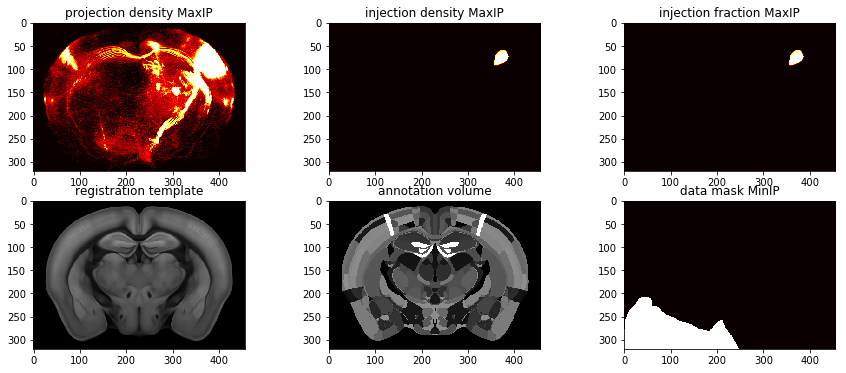

In [13]:
# compute the maximum intensity projection of the projection density
pd_mip = pd.max(axis=0)
ind_mip = ind.max(axis=0)
inf_mip = inf.max(axis=0)
dm_mip = dm.min(axis=0)

# show that slice of all volumes side-by-side
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 6))

ax1.imshow(pd_mip, cmap='hot', aspect='equal')
ax1.set_title("projection density MaxIP")

ax2.imshow(ind_mip, cmap='hot', aspect='equal')
ax2.set_title("injection density MaxIP")

ax3.imshow(inf_mip, cmap='hot', aspect='equal')
ax3.set_title("injection fraction MaxIP")

# pick a slice to show
slice_idx = int(template.shape[0] / 2)

ax4.imshow(template[slice_idx,:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ax4.set_title("registration template")

ax5.imshow(annot[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
ax5.set_title("annotation volume")

ax6.imshow(dm_mip, cmap='hot', aspect='equal', vmin=0, vmax=1)
ax6.set_title('data mask MinIP')

plt.show()